### Linear Robust MPC

This notebook showcases the usage of [linear tube-MPC](../ampyc/controllers/robust_mpc.py) [1] with ellipsoidal tubes. The accompanying notes for this notebook are [here](../notes/03_robustNMPC1.pdf).

[1] D. Q. Mayne, M. M. Seron, and S. V. Rakovic, "Robust model predictive control of constrained linear systems with bounded disturbances", Automatica, 2005.

In [6]:
# import numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

# import the default parameters, the linear system, and the tube-MPC controller
from ampyc.params import RMPCParams
from ampyc.systems import LinearSystem
from ampyc.controllers import RMPC

# import additional utilities from ampyc (plotting and RoA computation)
from ampyc.plotting import plot_x_state_time, plot_x_state_state, plot_u, plot_tubes
from ampyc.utils import compute_RoA

First, we instantiate the linear system and the tube-MPC using the loaded default parameters

In [2]:
params = RMPCParams()
sys = LinearSystem(params.sys)
ctrl = RMPC(sys, params.ctrl)

Successfully initialized experiment 'robust linear MPC'.


Next, we compute and plot the ellipsoidal tube that is used in tube-MPC. The size of the tube is governed by the contraction rate rho. You can try various values for rho and observe the produced plots.

Note: Choose a value for rho making sure the resulting RPI set is contained in the state constraints

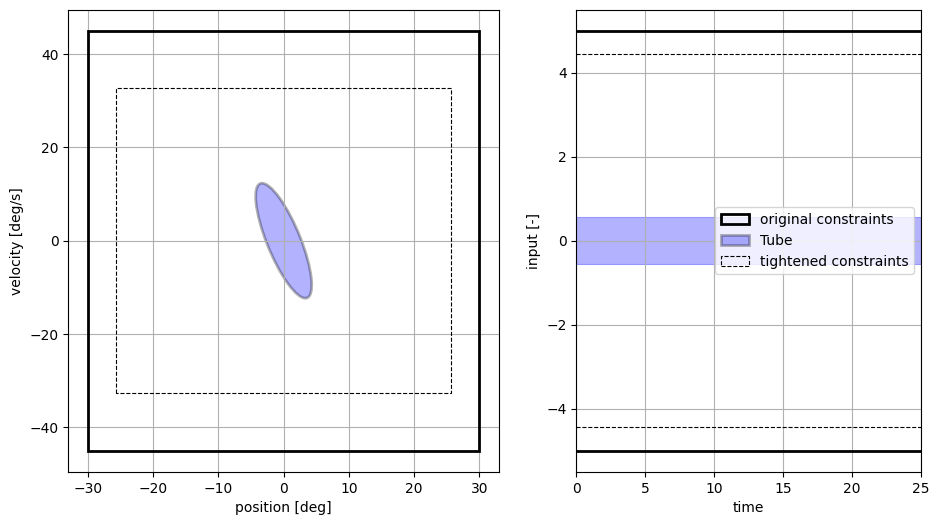

In [9]:
# compute the ellipsoidal tube
rho = 0.8
_, _, F, K, delta = ctrl.compute_tightening(rho)

# convert state sets to degrees for plotting
X_deg = (180/np.pi) * sys.X
conversion_factor = (np.pi/180)**2
F_deg = conversion_factor/delta**2 * F # also normalize by delta

# undo conversion for input constraints
K_deg = np.sqrt(conversion_factor)*K

# plot
plot_tubes(1, F_deg, K_deg, X_deg, sys.U, params.plot, state_axes=['position [deg]', 'velocity [deg/s]'], input_axes=['input [-]'])

After choosing a suitable rho, we re-initialize tube-MPC and simulate it in closed-loop with the linear system

In [ ]:
# re-initialize the controller with the chosen rho
ctrl = RMPC(sys, params.ctrl, rho)

# set random seed for reproducibility
sys.noise_generator.seed(42)

# get the simulation parameters
num_steps = params.sim.num_steps
num_traj = params.sim.num_traj

# get the initial state from the parameters
x_0 = params.sim.x_0

# allocate state and input trajectories
x = np.zeros((num_steps+1, sys.n, num_traj))
u = np.zeros((num_steps, num_traj))
x[0,:,:] = x_0

# simulate the closed-loop system
for i in range(num_traj):
    for j in range(num_steps):
        # get the control input by solving the MPC problem
        sol_v, sol_z, error_msg = ctrl.solve(x[j,:,i], additional_parameters={}, verbose=False)
        
        # check if the solver returned an error
        if error_msg != None:
            raise Exception(error_msg)
        
        # compute the control law
        pi = sol_v[:,0] + ctrl.K @ (x[j,:,i] - sol_z[:,0])

        # advance the system
        u[j,i] = pi.item() # need .item(), since u is a scalar
        x[j+1,:,i] = sys.get_state(x[j,:,i], u[j,i]).reshape(-1) # here we directly use the get_state method, since the output equation is the identity

Then, we can plot the closed-loop trajectories. We do this in angular coordinates, since the system we are simulating is a simplified segway model.

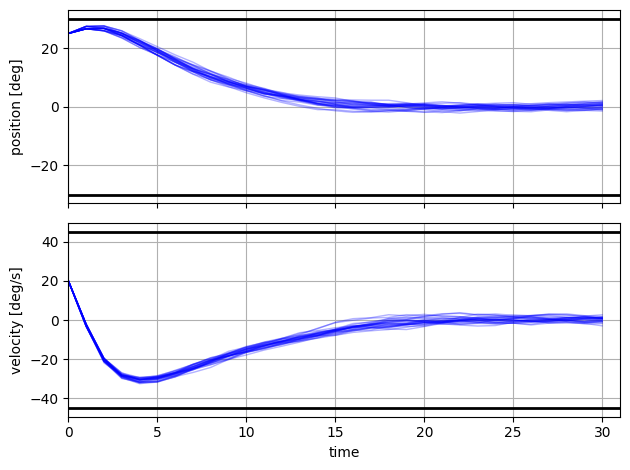

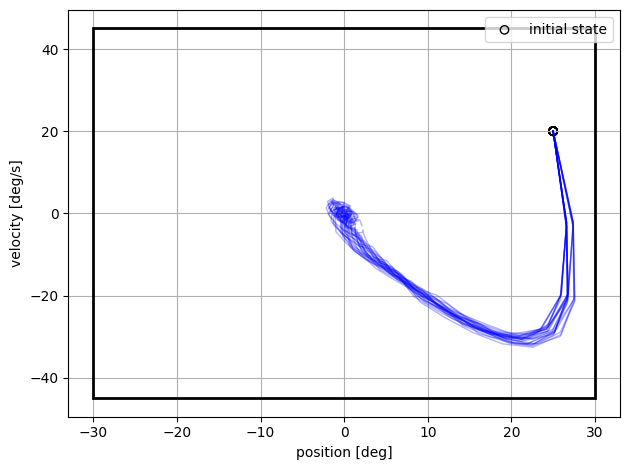

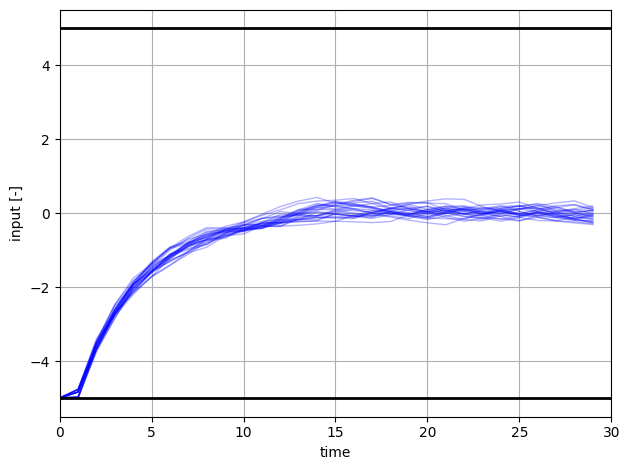

In [11]:
# convert the state trajectory and the state constraints to degrees for plotting
x_deg = np.rad2deg(x)
X_deg = (180/np.pi) * sys.X

# plot the closed-loop state and input trajectories
plot_x_state_time(1, x_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_x_state_state(2, x_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_u(3, u, sys.U, params.plot, axes_labels=['input [-]'])

Finally, we compute the region of attraction (RoA), i.e., the set of initial states for which the tube-MPC is feasible.

Note: Since computing the RoA will include solving the MPC for initial states close to infeasibility, you might encounter solver warnings regarding numerical inaccuracies. Here, these warnings can be safely ignored.

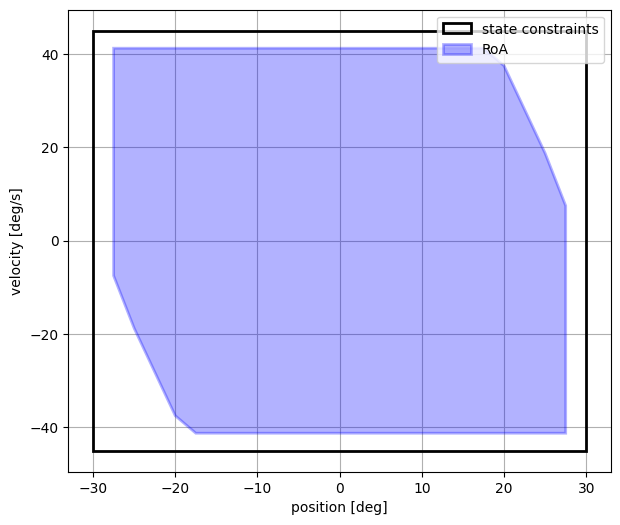

In [14]:
# NOTE: running this cell might take a while
_, ax = plt.subplots(1, 1, figsize=(7, 6))

# compute the RoA
RoA = compute_RoA(ctrl, sys, solver="ECOS")

# convert state constraints and RoA to degrees for plotting
X_deg = (180/np.pi) * sys.X
RoA = (180/np.pi) * RoA

# plot the RoA and the state constraints
X_deg.plot(ax=ax, fill=False, color='black', alpha=1.0, linewidth=2, label='state constraints')
RoA.plot(ax=ax, color='blue', alpha=0.3, edgecolor='blue', linewidth=2, label='RoA')

# set the axis labels and limits
ax.set_xlabel('position [deg]')
ax.set_ylabel('velocity [deg/s]')
ax.set_xlim(X_deg.xlim)
ax.set_ylim(X_deg.ylim)

# add a grid and the legend
plt.grid()
plt.legend(loc='upper right')
plt.show()